In [ ]:
!nvidia-smi

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0B:00.0)


In [3]:
%%time
mapper = {}
for key in range(  30,   35): mapper[key] = 32
for key in range(  70,   75): mapper[key] = 72
for key in range( 115,  120): mapper[key] = 117
for key in range( 170,  175): mapper[key] = 172
for key in range( 255,  270): mapper[key] = 260
for key in range( 355,  370): mapper[key] = 360
for key in range( 495,  510): mapper[key] = 500
for key in range( 655,  670): mapper[key] = 660
for key in range( 815,  830): mapper[key] = 820
for key in range(1010, 1030): mapper[key] = 1020

print("Loading in the frame.")
filepath   = "data/sets/progenitors/ACTS.gz"
events     = utils.list_of_groups(pd.read_csv(filepath), "event_id")
frame      = pd.concat([event for event in events if metrics.number_of_tracks(event) <= 25])
frame["r"] = frame["r"].round().map(mapper)
frame.drop_duplicates(["event_id", "cluster_id", "r"], keep="first", inplace=True)
print("Preparing the frame.")
frame = ext.prepare_frame(frame, n_tracks=25, n_rows=260, n_noise=10)
frame = frame.sample(frac=1)
print(frame["cluster_id"].max())
print("Saving the frame.")
frame.to_csv("data/sets/ACTS-10N-25T.gz", compression="gzip")

Loading in the frame.
Preparing the frame.
26
Saving the frame.
CPU times: user 7min 43s, sys: 2.25 s, total: 7min 46s
Wall time: 7min 45s


In [4]:
%%time
modelpath = "data/models/ACTS-10N-25T-260R.h5"
filepath  = "data/sets/ACTS-10N-25T.gz"
frame     = pd.read_csv(filepath)
events    = [event for (_, event) in frame.groupby("event_id", sort=False)]
percent   = 0.8
cutoff    = int(percent * len(events))
train, test = events[:cutoff], events[cutoff:]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
if (not utils.is_prepared(train[0])) or (not utils.is_prepared(test[0])):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py") 

Train is list of 13232 events.
Test is list of 3308 events.
CPU times: user 7.03 s, sys: 96 ms, total: 7.13 s
Wall time: 7.13 s


In [7]:
order = ["phi", "r", "z"]

In [ ]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

In [ ]:
dist = metrics.distributions(pd.concat(test))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

Train 2888
Number of Hits: 82
Number of Tracks: 11


<IPython.core.display.Javascript object>


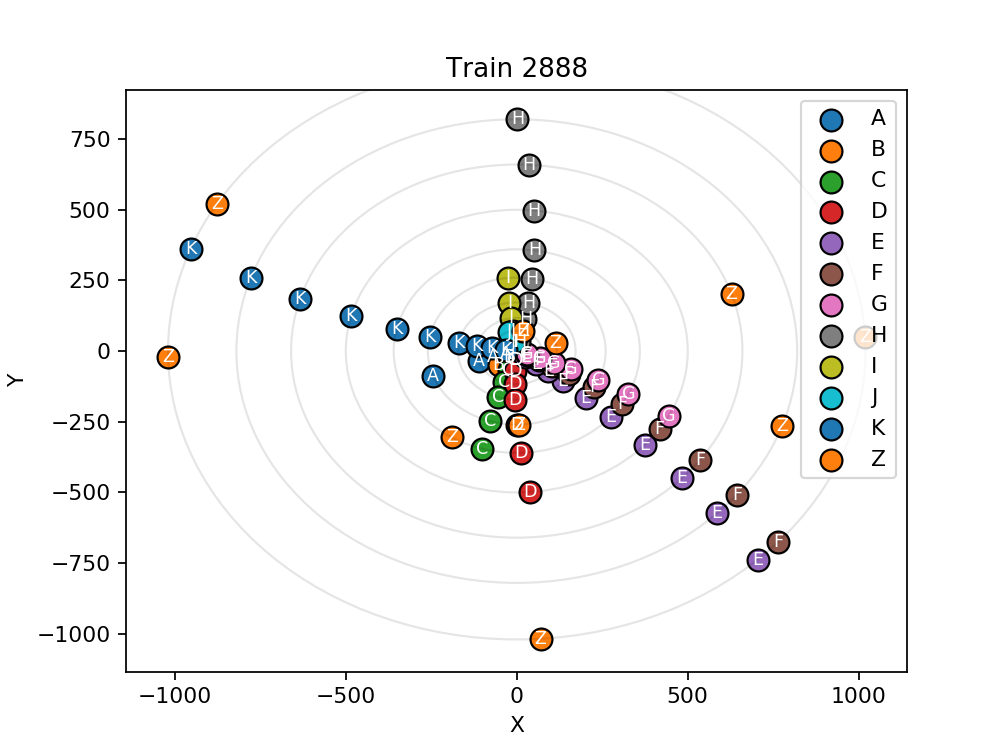

In [8]:
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [9]:
input_shape  = (260, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 260, 256)          399360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 260, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 260, 256)          787968    
_________________________________________________________________
dropout_2 (Dropout)          (None, 260, 256)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 260, 256)          787968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 260, 256)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 260, 27)           6939      
Total para

In [10]:
%%time
epochs     = 1
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,)]))

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Epoch 1/1
132/132 [==============================] - 218s - loss: 1.3163 - acc: 0.6681 - val_loss: 0.8408 - val_acc: 0.7002
CPU times: user 5min 44s, sys: 4.18 s, total: 5min 49s
Wall time: 5min 43s
